# case study group 23

> You are an employee of a fictitious company “106”, which sells gearshift systems to car manufacturers. In order to improve the product of the automatic gearshift system “K3AG1”, your company plans to analyze the damage cases of the last years. The automatic gearshift “K3AG1” is a standard component of the car brand “OEM1” and can be selected by the customer as an equipment feature of the car types “Type11” or “Type12”. From the management of your department you get the task to analyze the production data and parts lists of the customer and your suppliers. Key performance indicators such as service life, mileage, failure rates and usage data are of great importance.

## 1. Importing the data

In [33]:
import os
from typing import List
import pandas as pd
import numpy as np
def read_csv_auto(path: str) -> pd.DataFrame:
    """Read CSV with automatic delimiter detection and robust date parsing off (we'll parse later)."""
    df = pd.read_csv(path, sep=None, engine="python", dtype=str)
    # Drop typical unnamed index columns, if any
    df = df.loc[:, ~df.columns.str.contains(r"^Unnamed", case=False)]
    # Strip quotes/spaces from column names
    df.columns = df.columns.str.strip().str.replace('"', '', regex=False)
    # Strip surrounding quotes/spaces from string cells
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].map(lambda x: x.strip().strip('"') if isinstance(x, str) else x)
    return df

# Vehicles (baseline)
path_typ11 = "data/Fahrzeug/Fahrzeuge_OEM1_Typ11.csv"
path_typ12 = "data/Fahrzeug/Fahrzeuge_OEM1_Typ12.csv"

# Registrations
# path_reg   = "source/Zulassungen/Zulassungen_alle_Fahrzeuge.csv"

# Parts per vehicle
path_parts11 = "data/Fahrzeug/Bestandteile_Fahrzeuge_OEM1_Typ11.csv"
path_parts12 = "data/Fahrzeug/Bestandteile_Fahrzeuge_OEM1_Typ12.csv"

# Component (K3AG1)
path_k3ag1   = "data/Komponente/Komponente_K3AG1.csv"
# path_k3AG1_parts = "Bestandteile_Komponente_K3AG1.csv"

# Component (K3SG1)
path_k3sg1 = "data/Komponente/Komponente_K3SG1.csv"

df_typ11  = read_csv_auto(path_typ11)
df_typ12  = read_csv_auto(path_typ12)
# df_reg    = read_csv_auto(path_reg)
df_parts11 = read_csv_auto(path_parts11)
df_parts12 = read_csv_auto(path_parts12)
df_k3ag1  = read_csv_auto(path_k3ag1)
df_k3sg1 = read_csv_auto(path_k3sg1)


FileNotFoundError: [Errno 2] No such file or directory: 'data/Fahrzeug/Fahrzeuge_OEM1_Typ11.csv'

## 2. Data preparation

In [35]:
def coalesce_first(df: pd.DataFrame, candidates: List[str], new_name: str) -> pd.DataFrame:
    """
    Create/overwrite df[new_name] with the first existing, non-null column among candidates.
    If none exist, the column is created with NaN.
    """
    values = None
    for c in candidates:
        if c in df.columns:
            values = df[c] if values is None else values.fillna(df[c])
    df[new_name] = values if values is not None else np.nan
    return df

# Vehicles: ensure presence of the vehicle ID column name 'ID_Fahrzeug'
# (Some exports may have it quoted; read_csv_auto already strips quotes.)
if "ID_Fahrzeug" not in df_typ11.columns:
    # Attempt to find a close match; fallback to no-op if absent.
    pass
if "ID_Fahrzeug" not in df_typ12.columns:
    pass

# Tag vehicle type for provenance
if len(df_typ11):
    df_typ11["vehicle_type"] = "Typ11"
if len(df_typ12):
    df_typ12["vehicle_type"] = "Typ12"

# Baseline vehicles: stack, keep all columns; align by column name
df_vehicles_base = pd.concat([df_typ11, df_typ12], ignore_index=True, sort=False)

# Parts: unify the two parts tables and keep the shared columns
# Expected keys include: ID_Karosserie, ID_Schaltung, ID_Sitze, ID_Motor, ID_Fahrzeug
df_parts_all = pd.concat([df_parts11, df_parts12], ignore_index=True, sort=False)

# Registrations: standardize join key name to 'ID_Fahrzeug' and rename to English labels
# Some files name the vehicle ID as 'IDNummer'
# if "IDNummer" in df_reg.columns and "ID_Fahrzeug" not in df_reg.columns:
#     df_reg = df_reg.rename(columns={"IDNummer": "ID_Fahrzeug"})
# df_reg = df_reg.rename(columns={
#     "Gemeinden": "registration_municipality",
#     "Zulassung": "registration_date",
# })

def clean_k3_dataframe(df):
    df = coalesce_first(
        df,
        candidates=["ID_Schaltung", "ID_Schaltung.x", "ID_Schaltung.y"],
        new_name="ID_Schaltung"
    )   
    
    df = coalesce_first(df,
        ["Produktionsdatum", "Produktionsdatum.x", "Produktionsdatum.y"],
        "transmission_production_date"
    )
    df = coalesce_first(df,
        ["Herstellernummer", "Herstellernummer.x", "Herstellernummer.y"],
        "transmission_manufacturer_no"
    )
    df = coalesce_first(df,
        ["Werksnummer", "Werksnummer.x", "Werksnummer.y"],
        "transmission_plant_no"
    )
    df = coalesce_first(df,
        ["Fehlerhaft", "Fehlerhaft.x", "Fehlerhaft.y"],
        "transmission_defective_flag"
    )
    df = coalesce_first(df,
        ["Fehlerhaft_Datum", "Fehlerhaft_Datum.x", "Fehlerhaft_Datum.y"],
        "transmission_defective_date"
    )
    df = coalesce_first(df,
        ["Fehlerhaft_Fahrleistung", "Fehlerhaft_Fahrleistung.x", "Fehlerhaft_Fahrleistung.y"],
        "transmission_defective_mileage"
    )

    # Keep only the columns we standardized plus the join key
    keep_cols_k3 = [
        "ID_Schaltung",
        "transmission_production_date",
        "transmission_manufacturer_no",
        "transmission_plant_no",
        "transmission_defective_flag",
        "transmission_defective_date",
        "transmission_defective_mileage",
    ]

    keep_cols_k3 = [c for c in keep_cols_k3 if c in df.columns]
    df = df[keep_cols_k3].drop_duplicates()


    return df

df_k3 = pd.concat([df_k3ag1, df_k3sg1], axis = 0, ignore_index=True)
df_k3 = clean_k3_dataframe(df_k3)

NameError: name 'df_typ11' is not defined

## 3. Creation of the final dataset

In [37]:
# Merge with parts (by vehicle)
df_merged = df_vehicles_base.merge(
    df_parts_all,
    how="left",
    on="ID_Fahrzeug",
    suffixes=("", "_parts"),
    validate="m:1"
)

# Merge with K3AG1/K3SG1 component (by transmission ID from parts)
df_merged = df_merged.merge(
    df_k3,
    how="left",
    on="ID_Schaltung",
    validate="m:1"
)

rename_map = {
    "ID_Fahrzeug": "vehicle_id",
    "Produktionsdatum": "vehicle_production_date",
    "Herstellernummer": "vehicle_manufacturer_no",
    "Werksnummer": "vehicle_plant_no",
    "Fehlerhaft": "vehicle_defective_flag",
    "Fehlerhaft_Datum": "vehicle_defective_date",
    "Fehlerhaft_Fahrleistung": "vehicle_defective_mileage",
    "ID_Schaltung": "transmission_id"
}

df_merged = df_merged.rename(columns=rename_map)

date_like_cols = [c for c in [
    "registration_date",
    "transmission_production_date",
    "transmission_defective_date",
] if c in df_merged.columns]

for c in date_like_cols:
    try:
        parsed = pd.to_datetime(df_merged[c], errors="coerce")
        # Keep ISO-8601 string for portability
        df_merged[c] = parsed.dt.strftime("%Y-%m-%d")
    except Exception:
        # Leave as-is on any parsing issues
        pass

df_keeps = df_merged[[ 
    'vehicle_id', 
    'vehicle_production_date',
    'transmission_id', 
    'transmission_production_date',  'transmission_defective_flag',
    'transmission_defective_date', 'transmission_defective_mileage']]

# Ensure output directory exists
output_path = "Final_dataset_group_23.csv"

# Write CSV (UTF-8, comma delimiter, English-friendly headers we added remain in English)
df_keeps.to_csv(output_path, index=False, encoding="utf-8")
df_keeps.to_csv(f"{output_path}.gz", index=False, compression="gzip")   # gzip


NameError: name 'df_vehicles_base' is not defined

## 4. Evaluation

Part 1: Core Defect Analysis

--- 1.1 Loading the final dataset... ---
Final dataset loaded successfully!

--- 1.2 Performing data preprocessing... ---
Data preprocessing complete!

--- 1.3 Overall Defect Rate Analysis ---
Total samples: 2385260, Defective samples: 251994
Overall failure rate: 10.56%


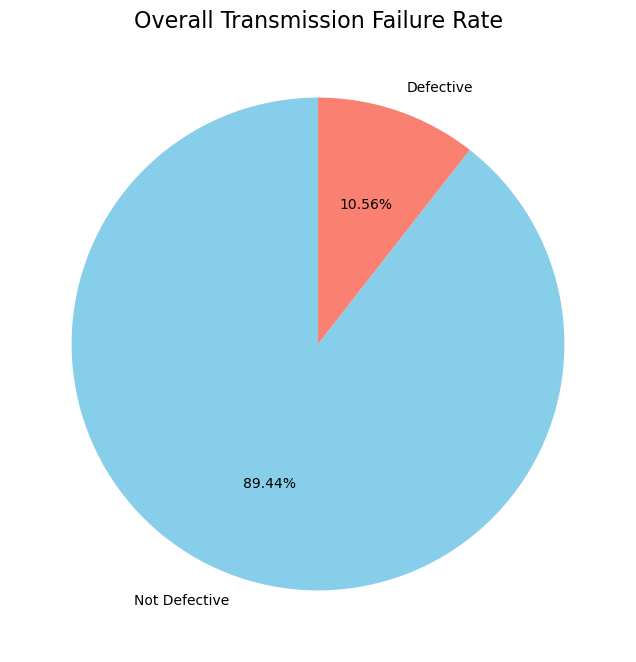


--- 1.4 Core Metrics Analysis of Defective Transmissions ---


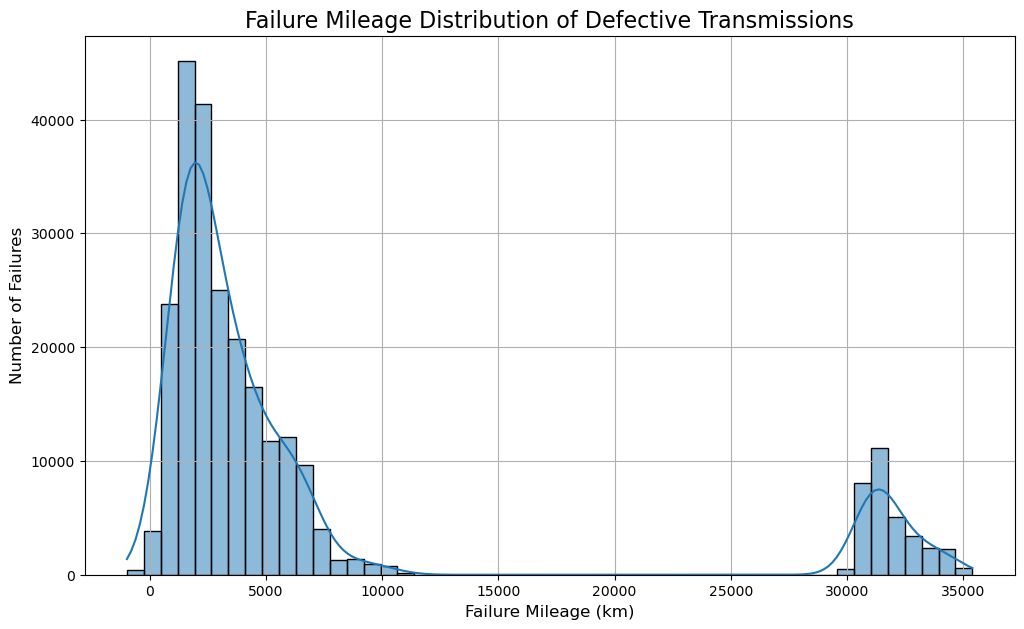


Core defect analysis complete!


In [3]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

FINAL_DATASET_FILE = Path("./Final_dataset_group_23.csv")

print("="*60)
print("Part 1: Core Defect Analysis")
print("="*60)

print("\n--- 1.1 Loading the final dataset... ---")
if not FINAL_DATASET_FILE.exists():
    raise FileNotFoundError(f"Final dataset file not found: '{FINAL_DATASET_FILE}'")
df = pd.read_csv(FINAL_DATASET_FILE, sep=",", encoding="utf-8")
print("Final dataset loaded successfully!")

print("\n--- 1.2 Performing data preprocessing... ---")
df['transmission_defective_flag'] = pd.to_numeric(df['transmission_defective_flag'], errors='coerce')
df['transmission_defective_mileage'] = pd.to_numeric(df['transmission_defective_mileage'], errors='coerce')
df['vehicle_production_date'] = pd.to_datetime(df['vehicle_production_date'], errors='coerce')
df['transmission_defective_date'] = pd.to_datetime(df['transmission_defective_date'], errors='coerce')
df['service_life_days'] = (df['transmission_defective_date'] - df['vehicle_production_date']).dt.days
df_defects = df[df['transmission_defective_flag'] == 1].copy()
print("Data preprocessing complete!")

print("\n--- 1.3 Overall Defect Rate Analysis ---")
total_count = len(df)
defective_count = len(df_defects)
failure_rate_overall = defective_count / total_count if total_count > 0 else 0
print(f"Total samples: {total_count}, Defective samples: {defective_count}")
print(f"Overall failure rate: {failure_rate_overall * 100:.2f}%")

plt.figure(figsize=(8, 8))
plt.pie([total_count - defective_count, defective_count], labels=['Not Defective', 'Defective'], autopct='%1.2f%%', startangle=90, colors=['skyblue', 'salmon'])
plt.title('Overall Transmission Failure Rate', fontsize=16)
plt.show()

print("\n--- 1.4 Core Metrics Analysis of Defective Transmissions ---")
if df_defects.empty:
    print("No valid defect records found to analyze mileage distribution.")
else:
    plt.figure(figsize=(12, 7))
    sns.histplot(df_defects['transmission_defective_mileage'].dropna(), bins=50, kde=True)
    plt.title("Failure Mileage Distribution of Defective Transmissions", fontsize=16)
    plt.xlabel("Failure Mileage (km)", fontsize=12)
    plt.ylabel("Number of Failures", fontsize=12)
    plt.grid(True)
    plt.show()

print("\nCore defect analysis complete!")


## 5. Result


Part 2: Logistics Delay Analysis

--- 2.1 Loading logistics delay file... ---
Logistics delay file loaded successfully!

--- 2.2 Logistics data analysis ---
Average delay: 6.08 days


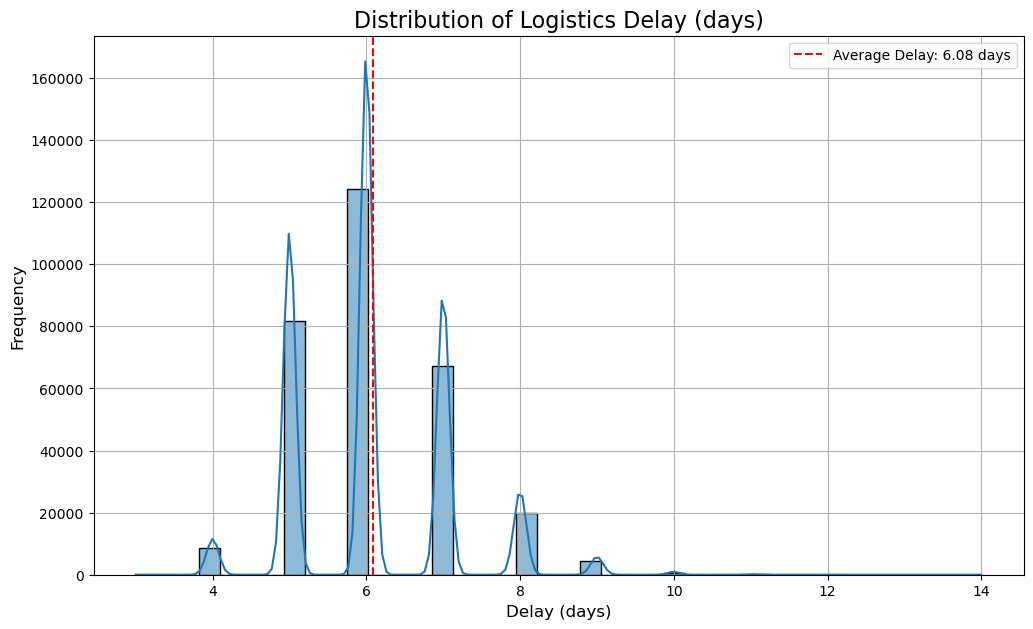


Logistics delay analysis complete!


In [5]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

LOGISTICS_FILE = Path("./logistics_delay.csv")

print("\n" + "="*60)
print("Part 2: Logistics Delay Analysis")
print("="*60)

print("\n--- 2.1 Loading logistics delay file... ---")
if not LOGISTICS_FILE.exists():
    print(f"Warning: Logistics delay file not found '{LOGISTICS_FILE}'. Skipping this analysis part.")
else:
    df_logistics = pd.read_csv(LOGISTICS_FILE, sep=",", encoding="utf-8")
    print("Logistics delay file loaded successfully!")

    print("\n--- 2.2 Logistics data analysis ---")
    
    delay_column = 'logistics_delay_days' 
    
    if delay_column in df_logistics.columns:
        df_logistics[delay_column] = pd.to_numeric(df_logistics[delay_column], errors='coerce')
        df_logistics.dropna(subset=[delay_column], inplace=True)
        
        average_delay = df_logistics[delay_column].mean()
        print(f"Average delay: {average_delay:.2f} days")

        plt.figure(figsize=(12, 7))
        sns.histplot(df_logistics[delay_column], bins=40, kde=True)
        plt.title('Distribution of Logistics Delay (days)', fontsize=16)
        plt.xlabel('Delay (days)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.axvline(average_delay, color='red', linestyle='--', label=f'Average Delay: {average_delay:.2f} days')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"Warning: The specified column '{delay_column}' was not found in the logistics file.")

print("\nLogistics delay analysis complete!")
